In [12]:
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain.document_loaders import PyPDFLoader
from langchain import text_splitter as ts
import pandas as pd
import glob
import os
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

In [2]:
folder = 'C:/Users/Carlini/Desktop/Gianluca/LLMs/Data/mixed_documents'
docs = glob.glob(os.path.join(folder, '**', '*.pdf'), recursive=True)

In [3]:
embedding_model = OllamaEmbeddings(model="mxbai-embed-large")

text_splitter = ts.RecursiveCharacterTextSplitter(
        chunk_size=6000, chunk_overlap=0
    )

In [4]:
embedded_docs = {}


for doc in tqdm(docs, desc='Embedding documents'):

    try:
        loader = PyPDFLoader(doc)

        doc_text = loader.load()

        all_splits = text_splitter.split_documents(doc_text)

        # take the first split only
        doc_text = all_splits[0].page_content

        embedded_docs[doc] = embedding_model.embed_query(doc_text)

    except Exception as e:
        print(f'Error while processing {doc}')



Embedding documents:  69%|██████▉   | 36/52 [00:53<00:13,  1.15it/s]

Error while processing C:/Users/Carlini/Desktop/Gianluca/LLMs/Data/mixed_documents\NLP\Big Bird Transformers for Longer Sequences.pdf


Embedding documents: 100%|██████████| 52/52 [01:15<00:00,  1.44s/it]


In [5]:
embedded_docs_df = pd.DataFrame.from_dict(embedded_docs, orient='index')

In [6]:
umap_modl = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)

umap_embeddings = umap_modl.fit_transform(embedded_docs_df)

umap_df = pd.DataFrame(umap_embeddings, index=embedded_docs_df.index, columns=['x', 'y'])

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, cluster_selection_epsilon=0.5, metric='euclidean')

umap_df['cluster'] = clusterer.fit_predict(umap_embeddings)

c:\Users\Carlini\miniconda3\envs\llama\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


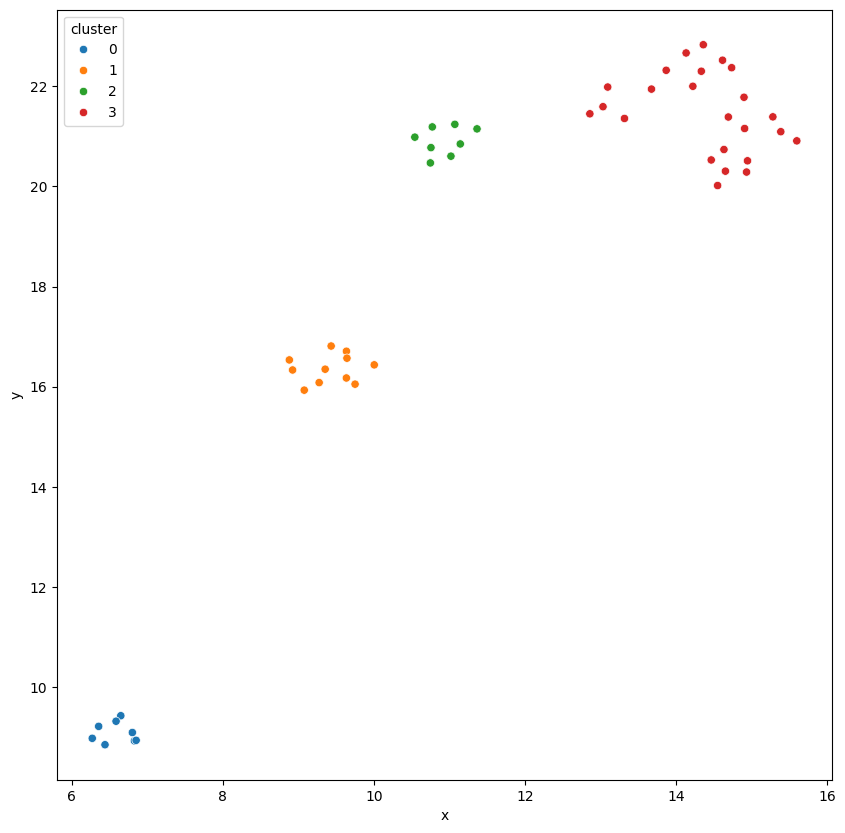

In [7]:
# plot

plt.figure(figsize=(10, 10))

sns.scatterplot(x='x', y='y', hue='cluster', palette='tab10', data=umap_df)

plt.show()


In [8]:
summarization_model = ChatOllama(model="llama3.2:3b-instruct-fp16")

clustered_docs = {}

for row in tqdm(umap_df.iterrows(), total=len(umap_df), desc='Summarizing clusters'):
    loader = PyPDFLoader(row[0])

    doc_text = loader.load()

    all_splits = text_splitter.split_documents(doc_text)

    # take the first split only
    doc_text = all_splits[0]

    # use the cluster number as key for the dictionary
    cluster = row[1]['cluster']

    if cluster not in clustered_docs:
        clustered_docs[cluster] = []

    clustered_docs[cluster].append(doc_text)


51it [00:58,  1.15s/it]


In [38]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "human",
            """Use one single keyword to describe the content of the following document: \\n \\n {context} \n
            Do not provide a summary of the document, just one keyword which is representative of the content""",
        )
    ]
)

# prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "human",
#             "write a concise summary of the following document: \\n \\n {context}",
#         )
#     ]
# )


chain = create_stuff_documents_chain(summarization_model, prompt)


In [39]:
keywords = {}

for key, value in tqdm(clustered_docs.items(), desc='Summarizing clusters'):
    
    docs = value
    
    result = chain.invoke({"context": docs})

    print(result)

    keywords[key] = result

Summarizing clusters:  25%|██▌       | 1/4 [00:00<00:01,  1.91it/s]

Paleogeology


Summarizing clusters:  50%|█████     | 2/4 [00:00<00:00,  2.26it/s]

Multiple sclerosis


Summarizing clusters:  75%|███████▌  | 3/4 [00:01<00:00,  2.47it/s]

transformer


Summarizing clusters: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

Pathology


In [40]:
keywords

{0.0: 'Paleogeology',
 3.0: 'Multiple sclerosis',
 1.0: 'transformer',
 2.0: 'Pathology'}

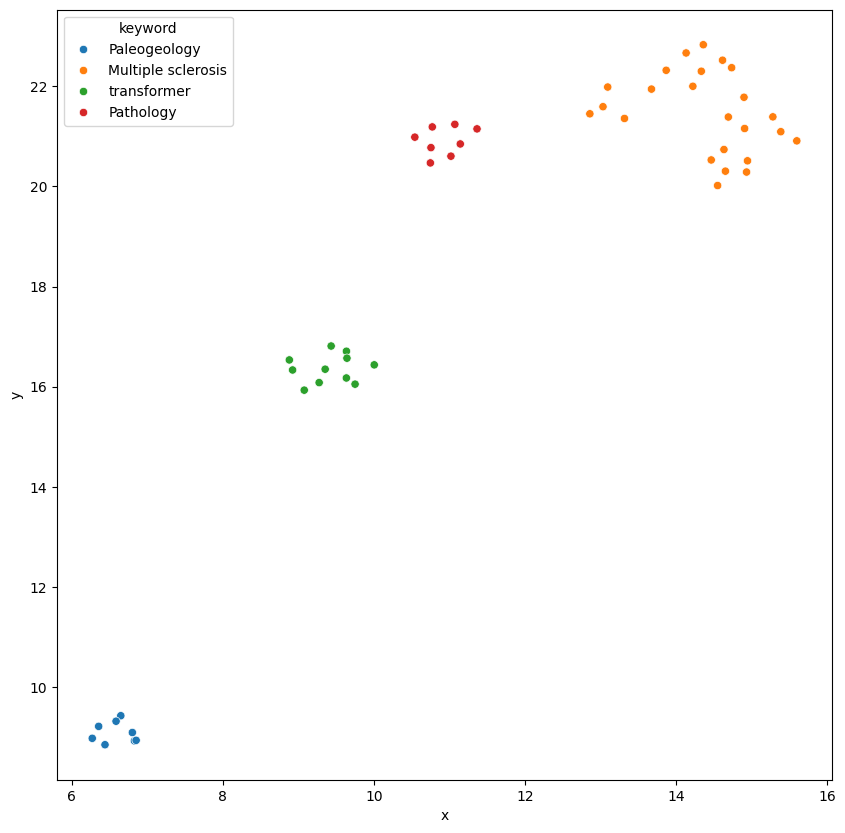

In [41]:
# plot assignig the keywords to the clusters

umap_df['keyword'] = umap_df['cluster'].map(keywords)

plt.figure(figsize=(10, 10))

sns.scatterplot(x='x', y='y', hue='keyword', palette='tab10', data=umap_df)

plt.show()

